In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import colorsys
import random

In [20]:
def erosion(image,diameter):
    img=np.pad(image,((diameter//2,diameter//2),(diameter//2,diameter//2)),'constant')
    out=np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j]=np.min(img[i:i+diameter,j:j+diameter])
    return out

def dialation(image,diameter):
    img=np.pad(image,((diameter//2,diameter//2),(diameter//2,diameter//2)),'constant')
    out=np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j]=np.max(img[i:i+diameter,j:j+diameter])
    return out

In [34]:
def TPA(image):
    cluster=np.zeros(image.shape,dtype=np.int64)
    count=0
 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i==0:
                if j==0 and image[i,j]==1:
                    count=count+1
                    cluster[i,j]=count   
                else:
                    if image[i,j]==1 and image[i,j-1]==1:
                        cluster[i,j]=cluster[i,j-1]
                    elif image[i,j]==1:
                        count=count+1
                        cluster[i,j]=count
            else:
                if j==0 and image[i,j]==1 and image[i-1,j]==1:
                    cluster[i,j]=cluster[i-1,j]
                elif j==0 and image[i,j]==1:
                    count=count+1
                    cluster[i,j]=count
                elif image[i,j]==1 and image[i-1,j]==1 and image[i,j-1]==1:
                    cluster[i,j]=min(cluster[i-1,j],cluster[i,j-1])
                 
                elif image[i,j]==1 and image[i-1,j]==1 and image[i,j-1]==0:
                    cluster[i,j]=cluster[i-1,j]
                elif image[i,j]==1 and image[i-1,j]==0 and image[i,j-1]==1:
                    cluster[i,j]=cluster[i,j-1]
                elif image[i,j]==1 and image[i-1,j]==0 and image[i,j-1]==0:
                    count=count+1
                    cluster[i,j]=count
    
    mapping=np.arange(count+1)
    
    for i in range(1,image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]==1:
                if j==0:
                    if cluster[i-1,j]!=cluster[i,j] and image[i-1,j]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i-1,j])]=min(cluster[i,j],cluster[i-1,j])
                else:
                    if cluster[i-1,j]!=cluster[i,j] and image[i-1,j]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i-1,j])]=min(cluster[i,j],cluster[i-1,j])
                    if cluster[i,j]!=cluster[i,j-1] and image[i,j-1]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i,j-1])]=min(cluster[i,j],cluster[i,j-1])


    
    for i in range(count+1):
        if i!=mapping[i]:
            temp=i
            val=mapping[i]
            while temp!=val:
                temp=val
                val=mapping[temp]
            mapping[i]=val
    
    result=cluster.copy()      
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i,j]=mapping[cluster[i,j]]
    return [result,mapping]

Text(0.5, 1.0, 'Original Image')

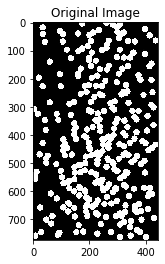

In [47]:
image=cv.cvtColor(cv.imread('../images/coins.jpg'),cv.COLOR_BGR2GRAY)
plt.imshow(image,"gray")
plt.title("Original Image")

8148
(773, 444)
Number of Pixels 5913


Text(0.5, 1.0, 'Coins touching Boundary')

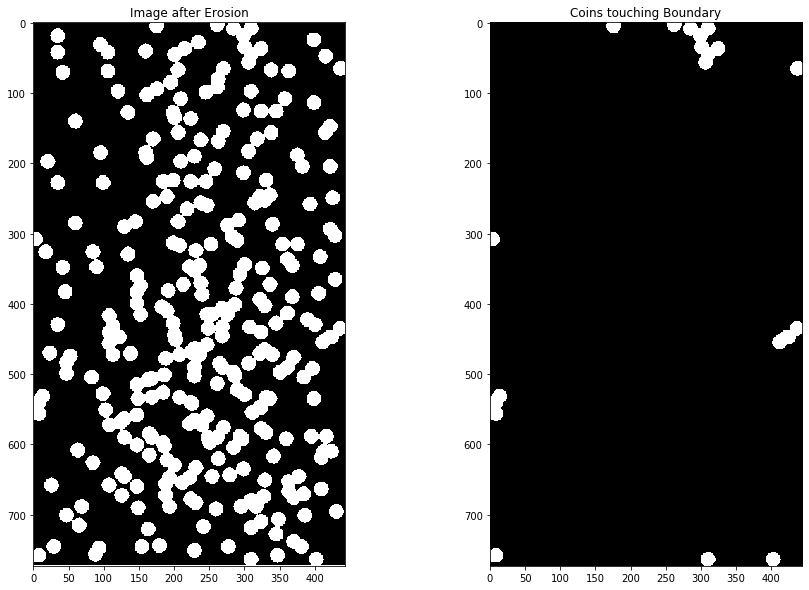

In [45]:

#Binarization of image
(T,binary_image)=cv.threshold(image,128,255,cv.THRESH_BINARY)
binary_image=binary_image//255
bin_image=binary_image.copy()

#Performing Erosion 
binary_image=erosion(binary_image,2)
erosion_img = np.copy(binary_image)
#Making the border values of binary_img = 1
boundary_coins=np.zeros(binary_image.shape)
binary_image[:,0]=1
binary_image[0,:]=1
binary_image[:,binary_image.shape[1]-1]=1
binary_image[binary_image.shape[0]-1]=1

# print(boundary_coins.shape,binary_image.shape,bin_image.shape)

#Performing Two Pass ALgorithm
[twopass_image,clustermap]=TPA(binary_image)
#Number of pixels with label  = 1
print(np.sum(twopass_image==1))
print(binary_image.shape)

#Checking if it is border element and has white coin i.e bin_img[i,j] == 1
ans  = 0 
for i in range(binary_image.shape[0]):
    for j in range(binary_image.shape[1]):
        if bin_image[i,j]==1 and twopass_image[i,j]==1:
            ans +=1
            boundary_coins[i,j]=1
print("Number of Pixels touching boundary",ans)



f, axarr = plt.subplots(1,2,figsize=(15,10))
axarr[0].imshow(binary_image,cmap="gray")
axarr[1].imshow(boundary_coins,cmap="gray")
axarr[0].set_title("Image after Erosion")
axarr[1].set_title("Coins touching Boundary")

### Approach: -
1. After Performing two pass algorithm, we initialize unitersected array to zeros and intersected array to given image
2. Then, for each label, after finding the number of occurrences of it, for threshold <500 count, mark it as unintersected otherwise intersected

Text(0.5, 1.0, 'Intersected Coins')

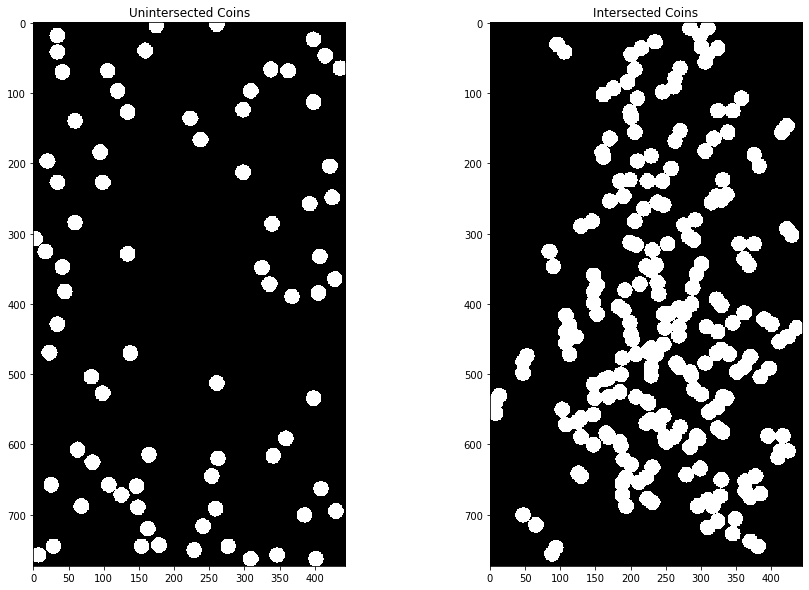

In [36]:
img=cv.imread('../images/coins.jpg',0)
(T,binary_image)=cv.threshold(img,128,255,cv.THRESH_BINARY)

# plt.imshow(binary_image,cmap='gray')
# plt.show()

binary_image=binary_image//255

[twopass_image,clustermap]=TPA(binary_image)

unique,count=np.unique(twopass_image,return_counts=True)

unintersected=np.zeros(twopass_image.shape)
intersected=binary_image.copy()

# print(twopass_image)
# print(unique)
# print(count)
# print(count.min())
for i in range(unique.size):
    if count[i]<500:
        unintersected[twopass_image==unique[i]]=1
        intersected[twopass_image==unique[i]]=0
#         plt.imshow(unintersected,cmap="gray")
#         plt.show()
    
f, axarr = plt.subplots(1,2,figsize=(15,10))
axarr[0].imshow(unintersected,cmap="gray")
axarr[1].imshow(intersected,cmap="gray")
axarr[0].set_title("Unintersected Coins")
axarr[1].set_title("Intersected Coins")   

In [29]:
# def random_colors(N, bright=True):
#     brightness = 1.0 if bright else 0.4
#     hsv = [(i/(N+1), i/2*N, brightness) for i in range(N)]
#     colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
#     return np.array(colors) 

In [30]:
# colors = random_colors(clustermap.size)
# segmented_image = np.zeros((twopass_image.shape[0],twopass_image.shape[1],3),dtype=np.uint8)

# for i in range(twopass_image.shape[0]):
#     for j in range(twopass_image.shape[1]):
#         if twopass_image[i,j]==0:
#             segmented_image[i,j,:] = 0
#         else:
#             segmented_image[i,j,:] = colors[twopass_image[i,j]]
#             segmented_image[i,j,:] *= 255
# # u,c=np.unique(colors,return_counts=True,axis=0)
# fig = plt.figure()
# fig.set_size_inches(10, 10)
# plt.imshow(segmented_image)
# plt.show()